<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 15px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 20px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2.5rem; font-weight: bold;">📃Fine-Tuning BERT for BBC Articles Detection📃</h1>
    <p style="text-align: center; font-size: 1.1rem;">Created by <strong>Ahmed Saqr</strong> </p> 
  </div>
</div>

<img src="https://ichef.bbci.co.uk/news/1024/branded_news/11843/production/_130074717_bbcnewsfaqs.jpg" alt="Paris" style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 80%;"> 

<div style="font-family: Arial, Helvetica, sans-serif; background-color: #f7f7f7; padding: 15px; border-radius: 8px;">
    <!-- Introduction/Overview Section -->
    <div style="background-color: #b80000; color: white; padding: 20px; border-radius: 8px;">
        <div style="margin-top: 30px;">
            <h2 aria-label="Dataset Overview" style="font-size: 1.6rem;font-weight: bold;">📊 Dataset Description</h2>
            <p style="font-size: 1.2rem;">
                The dataset used in this project consists of BBC articles, aimed at categorizing various types of news content. The dataset includes a total of 2,225 rows and is organized into two main columns:
            </p>
            <ul style="font-size: 1.1rem;">
                <li><strong>text</strong> - This column contains the body of the BBC articles. Each row represents a unique article, providing a detailed textual description of the content covered. These articles encompass diverse topics ranging from current events to specialized subjects, enabling effective analysis and categorization.</li>
                <li><strong>labels</strong> - This column holds the corresponding category for each article. Categories are predefined and indicate the topic or genre of the article. These labels serve as target variables for classification tasks, making this dataset suitable for training and evaluating machine learning models focused on text classification.</li>
            </ul>
            <p style="font-size: 1.2rem;">
                The structured format of the dataset—paired articles with their respective categories—provides an excellent foundation for exploring Natural Language Processing (NLP) techniques, enabling tasks such as supervised learning and category prediction.
            </p>
        </div>
    </div>
</div>

<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 5px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 10px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2rem; font-weight: bold;">📥Import Necessary Libraries</h1>
  </div>
</div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import datasets
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate

<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 5px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 10px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2rem; font-weight: bold;">🔄Load the Data</h1>
  </div>
</div>

In [2]:
df = pd.read_csv("data/bbc_text_cls.csv")

In [3]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 5px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 10px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2rem; font-weight: bold;">🔎Check of Data</h1>
  </div>
</div>

In [4]:
print(f"the shape of Data: {df.shape}")

the shape of Data: (2225, 2)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [6]:
print("Number of Missing values:")
df.isnull().sum()

Number of Missing values:


text      0
labels    0
dtype: int64

In [7]:
print(f"Number of Duplicates: {df.duplicated().sum()}")

Number of Duplicates: 98


In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df["labels"].value_counts()

labels
sport            505
business         503
politics         403
entertainment    369
tech             347
Name: count, dtype: int64

<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 5px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 10px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2rem; font-weight: bold;">📊Exploratory Data Analysis</h1>
  </div>
</div>

In [10]:
labels_count = df["labels"].value_counts()

fig = px.pie(names=labels_count.index, values=labels_count.values, 
             labels=labels_count.index, title="Labels Distribution")

fig.update_traces(textposition="inside", textinfo="percent+label")

In [11]:
df["text_len"] = df["text"].apply(len)

fig = px.histogram(df, x="text_len", color="labels", title="Text Length per Label",
                   barmode='stack', color_discrete_sequence=px.colors.qualitative.Bold)

fig.update_layout(xaxis_title="Text Length")
fig.show()

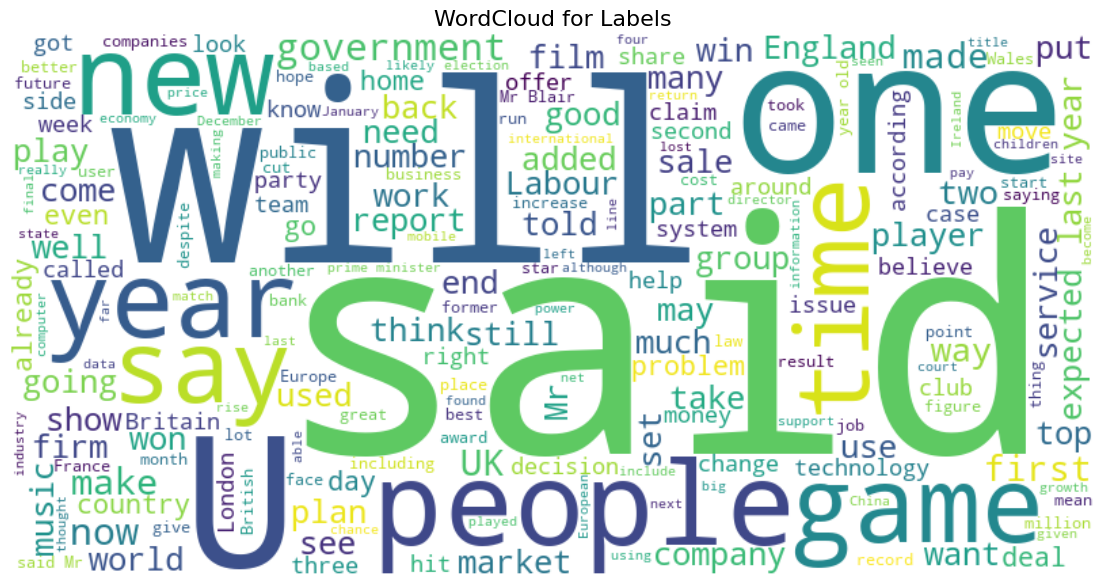

In [12]:
text = " ".join(df["text"])
text_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(14, 10))
plt.imshow(text_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Labels', fontsize=16)
plt.show()

<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 5px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 10px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2rem; font-weight: bold;">🔬Outlier Treatment</h1>
  </div>
</div>

In [13]:
df = df[df["text_len"] <= 6000]

df.shape

(2107, 3)

In [14]:
fig = px.histogram(df, x="text_len", color="labels", title="Text Length per Label",
                   barmode='stack', color_discrete_sequence=px.colors.qualitative.Bold)

fig.update_layout(xaxis_title="Text Length")
fig.show()

<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 5px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 10px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2rem; font-weight: bold;">🧮 Data Preprocessing</h1>
  </div>
</div>

In [61]:
encoder = LabelEncoder()

df["labels"] = encoder.fit_transform(df["labels"])

In [62]:
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = text.lower()

    text = text.replace('\n', ' ')
    
    text = re.sub(r'\d+', ' ', text)

    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    doc = nlp(text)
    
    cleaned_tokens = []
    for token in doc:
        if token.text not in STOP_WORDS and not token.is_punct and not token.is_space:
            cleaned_tokens.append(token.lemma_)

    cleaned_tokens = ' '.join(cleaned_tokens)
    
    return cleaned_tokens

df["text"] = df["text"].apply(clean_text)

In [63]:
dataset = df[["text", "labels"]]
dataset = datasets.Dataset.from_pandas(dataset)
dataset = dataset.train_test_split(0.2)
dataset.column_names

{'train': ['text', 'labels', '__index_level_0__'],
 'test': ['text', 'labels', '__index_level_0__']}

In [64]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(row):
    return tokenizer(row["text"], truncation=True, max_length=512)

dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1685 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 5px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 10px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2rem; font-weight: bold;">🏛️ Model Building</h1>
  </div>
</div>

In [65]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}


model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=4,
    lora_alpha=32,
    lora_dropout=0.01,
    target_modules = ["query"],
)

model = get_peft_model(model, peft_config)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
training_args = TrainingArguments(
    output_dir="./bbc_articles_detection_model",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.169621,{'accuracy': 0.966824644549763}
2,No log,0.075394,{'accuracy': 0.9786729857819905}
3,No log,0.076638,{'accuracy': 0.9834123222748815}
4,No log,0.052730,{'accuracy': 0.990521327014218}
5,No log,0.087445,{'accuracy': 0.9834123222748815}
6,No log,0.067588,{'accuracy': 0.985781990521327}
7,No log,0.078095,{'accuracy': 0.985781990521327}
8,No log,0.073315,{'accuracy': 0.990521327014218}
9,No log,0.076849,{'accuracy': 0.990521327014218}
10,0.133600,0.076888,{'accuracy': 0.990521327014218}


Trainer is attempting to log a value of "{'accuracy': 0.966824644549763}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9786729857819905}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9834123222748815}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.990521327014218}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9834123222748815}" of 

TrainOutput(global_step=530, training_loss=0.12635043446185454, metrics={'train_runtime': 676.8118, 'train_samples_per_second': 24.896, 'train_steps_per_second': 0.783, 'total_flos': 4027051837747500.0, 'train_loss': 0.12635043446185454, 'epoch': 10.0})

<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 5px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 10px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2rem; font-weight: bold;">📋 Evaluation</h1>
  </div>
</div>

In [67]:
results = trainer.evaluate()
print(results)

Trainer is attempting to log a value of "{'accuracy': 0.990521327014218}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.07688762247562408, 'eval_accuracy': {'accuracy': 0.990521327014218}, 'eval_runtime': 6.689, 'eval_samples_per_second': 63.089, 'eval_steps_per_second': 2.093, 'epoch': 10.0}


In [68]:
predictions = trainer.predict(dataset['test'])

preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids

accuracy = accuracy_score(labels, preds)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.990521327014218


In [69]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       104
           1       0.99      0.99      0.99        74
           2       0.99      1.00      0.99        78
           3       0.99      0.99      0.99        98
           4       1.00      1.00      1.00        68

    accuracy                           0.99       422
   macro avg       0.99      0.99      0.99       422
weighted avg       0.99      0.99      0.99       422



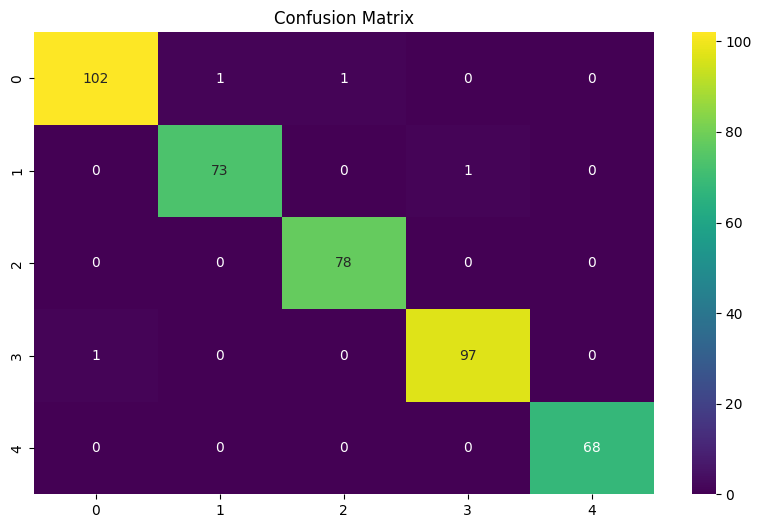

In [70]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

<div style="font-family: 'Arial', sans-serif; background-color: #f7f7f7; padding: 5px; border-radius: 8px;">
  <!-- Notebook Header Section -->
  <div style="background-color: #b80000; color: white; padding: 10px; border-radius: 8px;">
    <h1 style="text-align: center; font-size: 2rem; font-weight: bold;">📋 Save the Model</h1>
  </div>
</div>

In [71]:
save_directory = "./Model"

tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./Model
